# 0. Install and Import Dependencies

In [1]:
import os
import cv2
import tensorflow as tf
import numpy as np
from typing import List
from matplotlib import pyplot as plt
import imageio

2025-04-18 04:50:30.113809: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1744951830.276736    2174 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1744951830.313493    2174 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1744951830.717048    2174 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1744951830.717516    2174 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1744951830.717522    2174 computation_placer.cc:177] computation placer alr

In [2]:
tf.config.list_physical_devices('GPU')

2025-04-18 04:50:35.149292: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


[]

In [3]:
physical_devices = tf.config.list_physical_devices('GPU')
try:
    tf.config.experimental.set_memory_growth(physical_devices[0], True)
except:
    pass

# 1. Build Data Loading Functions

In [76]:
def load_video(path:str) -> List[float]: 

    cap = cv2.VideoCapture(path)
    frames = []
    for _ in range(int(cap.get(cv2.CAP_PROP_FRAME_COUNT))): 
        ret, frame = cap.read()
        frame = tf.image.rgb_to_grayscale(frame)
        # print(frame.shape)
        # if frame.shape[0] == 75:
        frames.append(frame[190:236,80:220,:])
    cap.release()
    
    mean = tf.math.reduce_mean(frames)
    std = tf.math.reduce_std(tf.cast(frames, tf.float32))
    return tf.cast((frames - mean), tf.float32) / std

In [77]:
ex_frame.shape[0]

75

In [78]:
ex_frame = load_video('./data/s1/bbal6n.mpg')

In [79]:
vocab = [x for x in "abcdefghijklmnopqrstuvwxyz'?!123456789 "]

In [80]:
char_to_num = tf.keras.layers.StringLookup(vocabulary=vocab, oov_token="")
num_to_char = tf.keras.layers.StringLookup(
    vocabulary=char_to_num.get_vocabulary(), oov_token="", invert=True
)

print(
    f"The vocabulary is: {char_to_num.get_vocabulary()} "
    f"(size ={char_to_num.vocabulary_size()})"
)

The vocabulary is: ['', np.str_('a'), np.str_('b'), np.str_('c'), np.str_('d'), np.str_('e'), np.str_('f'), np.str_('g'), np.str_('h'), np.str_('i'), np.str_('j'), np.str_('k'), np.str_('l'), np.str_('m'), np.str_('n'), np.str_('o'), np.str_('p'), np.str_('q'), np.str_('r'), np.str_('s'), np.str_('t'), np.str_('u'), np.str_('v'), np.str_('w'), np.str_('x'), np.str_('y'), np.str_('z'), np.str_("'"), np.str_('?'), np.str_('!'), np.str_('1'), np.str_('2'), np.str_('3'), np.str_('4'), np.str_('5'), np.str_('6'), np.str_('7'), np.str_('8'), np.str_('9'), np.str_(' ')] (size =40)


In [81]:
char_to_num.get_vocabulary()

['',
 np.str_('a'),
 np.str_('b'),
 np.str_('c'),
 np.str_('d'),
 np.str_('e'),
 np.str_('f'),
 np.str_('g'),
 np.str_('h'),
 np.str_('i'),
 np.str_('j'),
 np.str_('k'),
 np.str_('l'),
 np.str_('m'),
 np.str_('n'),
 np.str_('o'),
 np.str_('p'),
 np.str_('q'),
 np.str_('r'),
 np.str_('s'),
 np.str_('t'),
 np.str_('u'),
 np.str_('v'),
 np.str_('w'),
 np.str_('x'),
 np.str_('y'),
 np.str_('z'),
 np.str_("'"),
 np.str_('?'),
 np.str_('!'),
 np.str_('1'),
 np.str_('2'),
 np.str_('3'),
 np.str_('4'),
 np.str_('5'),
 np.str_('6'),
 np.str_('7'),
 np.str_('8'),
 np.str_('9'),
 np.str_(' ')]

In [82]:
char_to_num(['n','i','c','k'])

<tf.Tensor: shape=(4,), dtype=int64, numpy=array([14,  9,  3, 11])>

In [83]:
num_to_char([14,  9,  3, 11])

<tf.Tensor: shape=(4,), dtype=string, numpy=array([b'n', b'i', b'c', b'k'], dtype=object)>

In [84]:
def load_alignments(path:str) -> List[str]: 
    with open(path, 'r') as f: 
        lines = f.readlines() 
    tokens = []
    for line in lines:
        line = line.split()
        if line[2] != 'sil': 
            tokens = [*tokens,' ',line[2]]
    return char_to_num(tf.reshape(tf.strings.unicode_split(tokens, input_encoding='UTF-8'), (-1)))[1:]

In [93]:
ex_alignment = load_alignments("./data/alignments/s1/bbal6n.align")
print(ex_alignment)

tf.Tensor([ 2  9 14 39  2 12 21  5 39  1 20 39 12 39 19  9 24 39 14 15 23], shape=(21,), dtype=int64)


In [94]:
def load_data(path: str): 
    path = bytes.decode(path.numpy())
    file_name = path.split('/')[-1].split('.')[0]
    # File name splitting for windows
    # file_name = path.split('\\')[-1].split('.')[0]
    video_path = os.path.join('data','s1',f'{file_name}.mpg')
    alignment_path = os.path.join('data','alignments','s1',f'{file_name}.align')
    frames = load_video(video_path) 
    alignments = load_alignments(alignment_path)
    if frames.shape[0] == 75 and len(alignments):
        return frames, alignments
    else:
        print(f"Skipping {file_name}.mpg due to shape mismatch!!")

In [95]:
test_path = './data/s1/bbal6n.mpg'

In [96]:
tf.convert_to_tensor(test_path).numpy().decode('utf-8').split('/')[-1].split('.')[0]

'bbal6n'

In [97]:
frames, alignments = load_data(tf.convert_to_tensor(test_path))

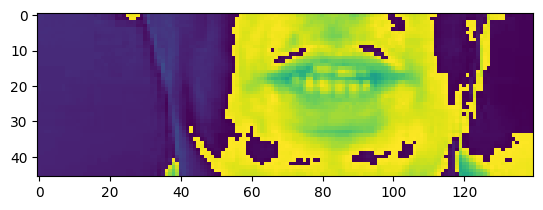

In [98]:
plt.imshow(frames[40])

In [99]:
alignments

<tf.Tensor: shape=(21,), dtype=int64, numpy=
array([ 2,  9, 14, 39,  2, 12, 21,  5, 39,  1, 20, 39, 12, 39, 19,  9, 24,
       39, 14, 15, 23])>

In [100]:
tf.strings.reduce_join([bytes.decode(x) for x in num_to_char(alignments.numpy()).numpy()])

<tf.Tensor: shape=(), dtype=string, numpy=b'bin blue at l six now'>

In [101]:
def mappable_function(path:str) ->List[str]:
    result = tf.py_function(load_data, [path], (tf.float32, tf.int64))
    return result

# 2. Create Data Pipeline

In [102]:
from matplotlib import pyplot as plt

In [103]:
data = tf.data.Dataset.list_files('./data/s1/*.mpg')
data = data.shuffle(500, reshuffle_each_iteration=True)
data = data.map(mappable_function)
data = data.padded_batch(2, padded_shapes=([75,None,None,None],[40]))
data = data.prefetch(tf.data.AUTOTUNE)
# Added for split 
train = data.take(450)
test = data.skip(450)

In [104]:
len(test)

50

In [105]:
frames, alignments = data.as_numpy_iterator().next()

In [106]:
len(frames)

2

In [107]:
sample = data.as_numpy_iterator()

In [108]:
val = sample.next(); val[0]

array([[[[[1.4640498 ],
          [1.4640498 ],
          [1.4265101 ],
          ...,
          [9.122157  ],
          [0.15015896],
          [0.18769869]],

         [[1.4640498 ],
          [1.4640498 ],
          [1.4265101 ],
          ...,
          [9.122157  ],
          [0.11261922],
          [0.18769869]],

         [[1.3138909 ],
          [1.3138909 ],
          [1.3514307 ],
          ...,
          [0.03753974],
          [0.26277816],
          [0.26277816]],

         ...,

         [[0.9384935 ],
          [0.9384935 ],
          [0.9384935 ],
          ...,
          [0.03753974],
          [0.        ],
          [0.        ]],

         [[0.9384935 ],
          [0.9384935 ],
          [0.9384935 ],
          ...,
          [9.572634  ],
          [9.572634  ],
          [9.572634  ]],

         [[0.9384935 ],
          [0.9384935 ],
          [0.9384935 ],
          ...,
          [9.572634  ],
          [9.572634  ],
          [9.572634  ]]],


        [[[1.4265

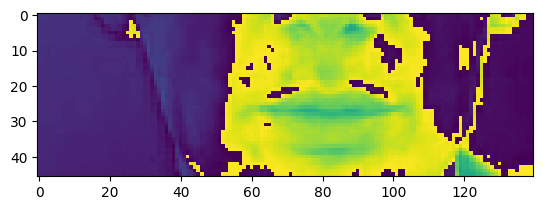

In [109]:
# 0:videos, 0: 1st video out of the batch,  0: return the first frame in the video 
plt.imshow(val[0][0][20])

In [110]:
tf.strings.reduce_join([num_to_char(word) for word in val[1][0]])

<tf.Tensor: shape=(), dtype=string, numpy=b'set red with i three soon'>

# 3. Design the Deep Neural Network

In [115]:
from tensorflow.keras.models import Sequential 
from tensorflow.keras.layers import Input, Conv3D, LSTM, Dense, Dropout, Bidirectional, MaxPool3D, Activation, Reshape, SpatialDropout3D, BatchNormalization, TimeDistributed, Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler

In [112]:
data.as_numpy_iterator().next()[0][0].shape

(75, 46, 140, 1)

In [121]:
model = Sequential()
model.add(Input(shape = (75,46,140,1)))
model.add(Conv3D(128, 3, padding='same'))
model.add(Activation('relu'))
model.add(MaxPool3D((1,2,2)))

model.add(Conv3D(256, 3, padding='same'))
model.add(Activation('relu'))
model.add(MaxPool3D((1,2,2)))

model.add(Conv3D(75, 3, padding='same'))
model.add(Activation('relu'))
model.add(MaxPool3D((1,2,2)))

model.add(TimeDistributed(Flatten()))

model.add(Bidirectional(LSTM(128, kernel_initializer='Orthogonal', return_sequences=True)))
model.add(Dropout(.5))

model.add(Bidirectional(LSTM(128, kernel_initializer='Orthogonal', return_sequences=True)))
model.add(Dropout(.5))

model.add(Dense(char_to_num.vocabulary_size()+1, kernel_initializer='he_normal', activation='softmax'))

In [122]:
model.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv3d_6 (Conv3D)               │ (None, 75, 46, 140,    │         3,584 │
│                                 │ 128)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_6 (Activation)       │ (None, 75, 46, 140,    │             0 │
│                                 │ 128)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d_6 (MaxPooling3D)  │ (None, 75, 23, 70,     │             0 │
│                                 │ 128)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d_7 (Conv3D)               │ (None, 75, 23, 70,     │       884,992 │
│                                 │ 256)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_7 (Activation)       │ (None, 75, 23, 70,     │             0 │
│                                 │ 256)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d_7 (MaxPooling3D)  │ (None, 75, 11, 35,     │             0 │
│                                 │ 256)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d_8 (Conv3D)               │ (None, 75, 11, 35, 75) │       518,475 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_8 (Activation)       │ (None, 75, 11, 35, 75) │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d_8 (MaxPooling3D)  │ (None, 75, 5, 17, 75)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_2              │ (None, 75, 6375)       │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_4 (Bidirectional) │ (None, 75, 256)        │     6,660,096 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 75, 256)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_5 (Bidirectional) │ (None, 75, 256)        │       394,240 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 75, 256)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 75, 41)         │        10,537 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 8,471,924 (32.32 MB)

 Trainable params: 8,471,924 (32.32 MB)

 Non-trainable params: 0 (0.00 B)

In [123]:
5*17*75

6375

In [124]:
yhat = model.predict(val[0])

1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step


In [125]:
tf.strings.reduce_join([num_to_char(x) for x in tf.argmax(yhat[0],axis=1)])

<tf.Tensor: shape=(), dtype=string, numpy=b'jjjjjjjj9999999999999999999999999999999999999999999999999999999999999999999'>

In [126]:
tf.strings.reduce_join([num_to_char(tf.argmax(x)) for x in yhat[0]])

<tf.Tensor: shape=(), dtype=string, numpy=b'jjjjjjjj9999999999999999999999999999999999999999999999999999999999999999999'>

In [127]:
model.input_shape

(None, 75, 46, 140, 1)

In [128]:
model.output_shape

(None, 75, 41)

# 4. Setup Training Options and Train

In [129]:
def scheduler(epoch, lr):
    if epoch < 30:
        return lr
    else:
        return lr * tf.math.exp(-0.1)

In [130]:
def CTCLoss(y_true, y_pred):
    batch_len = tf.cast(tf.shape(y_true)[0], dtype="int64")
    input_length = tf.cast(tf.shape(y_pred)[1], dtype="int64")
    label_length = tf.cast(tf.shape(y_true)[1], dtype="int64")

    input_length = input_length * tf.ones(shape=(batch_len, 1), dtype="int64")
    label_length = label_length * tf.ones(shape=(batch_len, 1), dtype="int64")

    loss = tf.keras.backend.ctc_batch_cost(y_true, y_pred, input_length, label_length)
    return loss

In [131]:
class ProduceExample(tf.keras.callbacks.Callback): 
    def __init__(self, dataset) -> None: 
        self.dataset = dataset.as_numpy_iterator()
    
    def on_epoch_end(self, epoch, logs=None) -> None:
        data = self.dataset.next()
        yhat = self.model.predict(data[0])
        decoded = tf.keras.backend.ctc_decode(yhat, [75,75], greedy=False)[0][0].numpy()
        for x in range(len(yhat)):           
            print('Original:', tf.strings.reduce_join(num_to_char(data[1][x])).numpy().decode('utf-8'))
            print('Prediction:', tf.strings.reduce_join(num_to_char(decoded[x])).numpy().decode('utf-8'))
            print('~'*100)

In [132]:
model.compile(optimizer=Adam(learning_rate=0.0001), loss=CTCLoss)

In [133]:
checkpoint_callback = ModelCheckpoint(os.path.join('LipNetmodels','checkpoint.weights.h5'), monitor='loss', save_weights_only=True) 

In [134]:
schedule_callback = LearningRateScheduler(scheduler)

In [135]:
example_callback = ProduceExample(test)

In [136]:
model.fit(train, epochs=1, callbacks=[checkpoint_callback, schedule_callback, example_callback], batch_size = 32)

2025-04-18 05:16:14.286193: W tensorflow/core/framework/op_kernel.cc:1857] OP_REQUIRES failed at reshape_op.h:65 : INVALID_ARGUMENT: Only one input size may be -1, not both 0 and 1
2025-04-18 05:16:14.286249: W tensorflow/core/framework/op_kernel.cc:1857] OP_REQUIRES failed at reshape_op.h:65 : INVALID_ARGUMENT: Only one input size may be -1, not both 0 and 1
2025-04-18 05:16:14.286274: W tensorflow/core/framework/op_kernel.cc:1857] OP_REQUIRES failed at reshape_op.h:65 : INVALID_ARGUMENT: Only one input size may be -1, not both 0 and 1
2025-04-18 05:16:14.286281: W tensorflow/core/framework/op_kernel.cc:1857] OP_REQUIRES failed at reshape_op.h:65 : INVALID_ARGUMENT: Only one input size may be -1, not both 0 and 1
2025-04-18 05:16:14.286301: W tensorflow/core/framework/op_kernel.cc:1857] OP_REQUIRES failed at reshape_op.h:65 : INVALID_ARGUMENT: Only one input size may be -1, not both 0 and 1
2025-04-18 05:16:14.286325: W tensorflow/core/framework/op_kernel.cc:1857] OP_REQUIRES failed a

InvalidArgumentError: Graph execution error:

Detected at node sequential_3_1/time_distributed_2_1/Reshape_10 defined at (most recent call last):
  File "<frozen runpy>", line 198, in _run_module_as_main

  File "<frozen runpy>", line 88, in _run_code

  File "/home/zeus/miniconda3/envs/cloudspace/lib/python3.12/site-packages/ipykernel_launcher.py", line 18, in <module>

  File "/home/zeus/miniconda3/envs/cloudspace/lib/python3.12/site-packages/traitlets/config/application.py", line 1075, in launch_instance

  File "/home/zeus/miniconda3/envs/cloudspace/lib/python3.12/site-packages/ipykernel/kernelapp.py", line 739, in start

  File "/home/zeus/miniconda3/envs/cloudspace/lib/python3.12/site-packages/tornado/platform/asyncio.py", line 205, in start

  File "/home/zeus/miniconda3/envs/cloudspace/lib/python3.12/asyncio/base_events.py", line 641, in run_forever

  File "/home/zeus/miniconda3/envs/cloudspace/lib/python3.12/asyncio/base_events.py", line 1986, in _run_once

  File "/home/zeus/miniconda3/envs/cloudspace/lib/python3.12/asyncio/events.py", line 88, in _run

  File "/home/zeus/miniconda3/envs/cloudspace/lib/python3.12/site-packages/ipykernel/kernelbase.py", line 545, in dispatch_queue

  File "/home/zeus/miniconda3/envs/cloudspace/lib/python3.12/site-packages/ipykernel/kernelbase.py", line 534, in process_one

  File "/home/zeus/miniconda3/envs/cloudspace/lib/python3.12/site-packages/ipykernel/kernelbase.py", line 437, in dispatch_shell

  File "/home/zeus/miniconda3/envs/cloudspace/lib/python3.12/site-packages/ipykernel/ipkernel.py", line 362, in execute_request

  File "/home/zeus/miniconda3/envs/cloudspace/lib/python3.12/site-packages/ipykernel/kernelbase.py", line 778, in execute_request

  File "/home/zeus/miniconda3/envs/cloudspace/lib/python3.12/site-packages/ipykernel/ipkernel.py", line 449, in do_execute

  File "/home/zeus/miniconda3/envs/cloudspace/lib/python3.12/site-packages/ipykernel/zmqshell.py", line 549, in run_cell

  File "/home/zeus/miniconda3/envs/cloudspace/lib/python3.12/site-packages/IPython/core/interactiveshell.py", line 3047, in run_cell

  File "/home/zeus/miniconda3/envs/cloudspace/lib/python3.12/site-packages/IPython/core/interactiveshell.py", line 3102, in _run_cell

  File "/home/zeus/miniconda3/envs/cloudspace/lib/python3.12/site-packages/IPython/core/async_helpers.py", line 128, in _pseudo_sync_runner

  File "/home/zeus/miniconda3/envs/cloudspace/lib/python3.12/site-packages/IPython/core/interactiveshell.py", line 3306, in run_cell_async

  File "/home/zeus/miniconda3/envs/cloudspace/lib/python3.12/site-packages/IPython/core/interactiveshell.py", line 3489, in run_ast_nodes

  File "/home/zeus/miniconda3/envs/cloudspace/lib/python3.12/site-packages/IPython/core/interactiveshell.py", line 3549, in run_code

  File "/tmp/ipykernel_2174/1184072282.py", line 1, in <module>

  File "/home/zeus/miniconda3/envs/cloudspace/lib/python3.12/site-packages/keras/src/utils/traceback_utils.py", line 117, in error_handler

  File "/home/zeus/miniconda3/envs/cloudspace/lib/python3.12/site-packages/keras/src/backend/tensorflow/trainer.py", line 371, in fit

  File "/home/zeus/miniconda3/envs/cloudspace/lib/python3.12/site-packages/keras/src/backend/tensorflow/trainer.py", line 219, in function

  File "/home/zeus/miniconda3/envs/cloudspace/lib/python3.12/site-packages/keras/src/backend/tensorflow/trainer.py", line 132, in multi_step_on_iterator

  File "/home/zeus/miniconda3/envs/cloudspace/lib/python3.12/site-packages/keras/src/backend/tensorflow/trainer.py", line 113, in one_step_on_data

  File "/home/zeus/miniconda3/envs/cloudspace/lib/python3.12/site-packages/keras/src/backend/tensorflow/trainer.py", line 57, in train_step

  File "/home/zeus/miniconda3/envs/cloudspace/lib/python3.12/site-packages/keras/src/utils/traceback_utils.py", line 117, in error_handler

  File "/home/zeus/miniconda3/envs/cloudspace/lib/python3.12/site-packages/keras/src/layers/layer.py", line 909, in __call__

  File "/home/zeus/miniconda3/envs/cloudspace/lib/python3.12/site-packages/keras/src/utils/traceback_utils.py", line 117, in error_handler

  File "/home/zeus/miniconda3/envs/cloudspace/lib/python3.12/site-packages/keras/src/ops/operation.py", line 52, in __call__

  File "/home/zeus/miniconda3/envs/cloudspace/lib/python3.12/site-packages/keras/src/utils/traceback_utils.py", line 156, in error_handler

  File "/home/zeus/miniconda3/envs/cloudspace/lib/python3.12/site-packages/keras/src/models/sequential.py", line 221, in call

  File "/home/zeus/miniconda3/envs/cloudspace/lib/python3.12/site-packages/keras/src/models/functional.py", line 183, in call

  File "/home/zeus/miniconda3/envs/cloudspace/lib/python3.12/site-packages/keras/src/ops/function.py", line 171, in _run_through_graph

  File "/home/zeus/miniconda3/envs/cloudspace/lib/python3.12/site-packages/keras/src/models/functional.py", line 643, in call

  File "/home/zeus/miniconda3/envs/cloudspace/lib/python3.12/site-packages/keras/src/utils/traceback_utils.py", line 117, in error_handler

  File "/home/zeus/miniconda3/envs/cloudspace/lib/python3.12/site-packages/keras/src/layers/layer.py", line 909, in __call__

  File "/home/zeus/miniconda3/envs/cloudspace/lib/python3.12/site-packages/keras/src/utils/traceback_utils.py", line 117, in error_handler

  File "/home/zeus/miniconda3/envs/cloudspace/lib/python3.12/site-packages/keras/src/ops/operation.py", line 52, in __call__

  File "/home/zeus/miniconda3/envs/cloudspace/lib/python3.12/site-packages/keras/src/utils/traceback_utils.py", line 156, in error_handler

  File "/home/zeus/miniconda3/envs/cloudspace/lib/python3.12/site-packages/keras/src/layers/rnn/time_distributed.py", line 127, in call

  File "/home/zeus/miniconda3/envs/cloudspace/lib/python3.12/site-packages/keras/src/layers/rnn/time_distributed.py", line 121, in step_function

  File "/home/zeus/miniconda3/envs/cloudspace/lib/python3.12/site-packages/keras/src/layers/reshaping/flatten.py", line 54, in call

  File "/home/zeus/miniconda3/envs/cloudspace/lib/python3.12/site-packages/keras/src/ops/numpy.py", line 4937, in reshape

  File "/home/zeus/miniconda3/envs/cloudspace/lib/python3.12/site-packages/keras/src/backend/tensorflow/numpy.py", line 2024, in reshape

Only one input size may be -1, not both 0 and 1
	 [[{{node sequential_3_1/time_distributed_2_1/Reshape_10}}]] [Op:__inference_multi_step_on_iterator_110409]

# 5. Make a Prediction 

In [138]:
import gdown

In [139]:
url = 'https://drive.google.com/uc?id=1vWscXs4Vt0a_1IH1-ct2TCgXAZT-N3_Y'
output = 'checkpoints.zip'
gdown.download(url, output, quiet=False)
gdown.extractall('checkpoints.zip', 'Trainedmodels')

Downloading...
From (original): https://drive.google.com/uc?id=1vWscXs4Vt0a_1IH1-ct2TCgXAZT-N3_Y
From (redirected): https://drive.google.com/uc?id=1vWscXs4Vt0a_1IH1-ct2TCgXAZT-N3_Y&confirm=t&uuid=1b3d1a7f-4b78-40b6-8e76-7d3d78bfb1c5
To: /teamspace/studios/this_studio/checkpoints.zip
100%|██████████| 94.5M/94.5M [00:01<00:00, 88.5MB/s]


['Trainedmodels/checkpoint.index',
 'Trainedmodels/__MACOSX/._checkpoint.index',
 'Trainedmodels/checkpoint.data-00000-of-00001',
 'Trainedmodels/__MACOSX/._checkpoint.data-00000-of-00001',
 'Trainedmodels/checkpoint',
 'Trainedmodels/__MACOSX/._checkpoint']

In [140]:
model.load_weights('Trainedmodels/checkpoint')

ValueError: File format not supported: filepath=Trainedmodels/checkpoint. Keras 3 only supports V3 `.keras` and `.weights.h5` files, or legacy V1/V2 `.h5` files.

In [54]:
test_data = test.as_numpy_iterator()

In [56]:
sample = test_data.next()

In [57]:
yhat = model.predict(sample[0])

1/1 [==============================] - 1s 973ms/step


In [58]:
print('~'*100, 'REAL TEXT')
[tf.strings.reduce_join([num_to_char(word) for word in sentence]) for sentence in sample[1]]

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ REAL TEXT


[<tf.Tensor: shape=(), dtype=string, numpy=b'place white at x six please'>,
 <tf.Tensor: shape=(), dtype=string, numpy=b'lay blue in x four now'>]

In [59]:
decoded = tf.keras.backend.ctc_decode(yhat, input_length=[75,75], greedy=True)[0][0].numpy()

In [60]:
print('~'*100, 'PREDICTIONS')
[tf.strings.reduce_join([num_to_char(word) for word in sentence]) for sentence in decoded]

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ PREDICTIONS


[<tf.Tensor: shape=(), dtype=string, numpy=b'place white at x six please'>,
 <tf.Tensor: shape=(), dtype=string, numpy=b'lay blue in x four now'>]

# Test on a Video

In [61]:
sample = load_data(tf.convert_to_tensor('.\\data\\s1\\bras9a.mpg'))

In [62]:
print('~'*100, 'REAL TEXT')
[tf.strings.reduce_join([num_to_char(word) for word in sentence]) for sentence in [sample[1]]]

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ REAL TEXT


[<tf.Tensor: shape=(), dtype=string, numpy=b'bin red at s nine again'>]

In [63]:
yhat = model.predict(tf.expand_dims(sample[0], axis=0))

1/1 [==============================] - 1s 720ms/step


In [64]:
decoded = tf.keras.backend.ctc_decode(yhat, input_length=[75], greedy=True)[0][0].numpy()

In [65]:
print('~'*100, 'PREDICTIONS')
[tf.strings.reduce_join([num_to_char(word) for word in sentence]) for sentence in decoded]

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ PREDICTIONS


[<tf.Tensor: shape=(), dtype=string, numpy=b'bin red at s nine again'>]